<a href="https://colab.research.google.com/github/Kat-ies/Diploma/blob/new_latent/Diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 0 : libs installing & func init**

In [ ]:
!git clone https://github.com/Kat-ies/stylegan2-pytorch.git
%cd /content/stylegan2-pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# need to be installed if it's not
!pip install Ninja

In [ ]:
!python model.py install

In [ ]:
import torch
from torchvision import transforms

def img_to_tensor(img):
    convert_tensor = transforms.ToTensor()
    return convert_tensor(img)

def tensor_to_img(tensor):
    conv = transforms.ToPILImage()
    return conv(tensor)

In [ ]:
import torch
from torchvision import utils
from model import Generator
from tqdm import tqdm
from PIL import Image
import math


def generator_params(img_size=1024, latent_len=512, n_mlp=8, chanel_miltiplier=2, ckpt ='stylegan2-ffhq-config-f.pt', device="cuda"):
    return (img_size, latent_len, n_mlp, chanel_miltiplier, ckpt, device)

def init_generator(img_size=1024, latent_len=512, n_mlp=8, chanel_miltiplier=2, ckpt ='stylegan2-ffhq-config-f.pt', device="cuda"):
    """
    small docs : 
    img_size = 1024 # output image size of the generator
    latent = 512
    n_mlp = 8
    channel_multiplier = 2
    ckpt = 'stylegan2-ffhq-config-f.pt' # channel multiplier of the generator. config-f = 2, else = 1
    """

    g_ema = Generator(img_size, latent_len, n_mlp, channel_multiplier=chanel_miltiplier).to(device)
    checkpoint = torch.load(ckpt)
    g_ema.load_state_dict(checkpoint["g_ema"], strict=False)

    return g_ema


# **Part 1**
Here we use StyleGAN-2 to generate image that we want to get as a result

In [ ]:
! rm -f /content/stylegan2-pytorch/sample/*

In [ ]:
#global variables

latent_len = 512
device = 'cuda'
torch.manual_seed(42)
truncation = 0.7
img_size=256

generator = init_generator(ckpt = '/content/drive/MyDrive/ДИ Диплом/models/550000.pt', img_size=img_size)
trunc = generator.mean_latent(int(math.log(img_size, 2)) * 2 - 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/content/stylegan2-pytorch/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.0+cu111. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


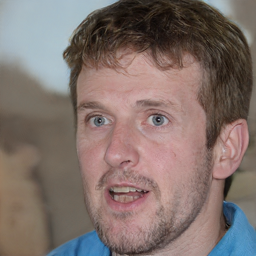

In [ ]:
torch.manual_seed(42)

sample_z = torch.randn(1, latent_len, dtype=torch.float32, device=torch.device(device))
latent_w = torch.tensor(generator.get_latent(sample_z))

goal_image, goal_latent = generator([latent_w], truncation=truncation, truncation_latent=trunc, input_is_latent=True, return_latents=True)

utils.save_image(
    goal_image,
    f"sample/goal.png",
    nrow=1,
    normalize=True,
    range=(-1, 1),
)

goal_image.to(device)

goal_img = Image.open('/content/stylegan2-pytorch/sample/goal.png')
goal_img

# **Part 2**
Here we will generate a new image and try to get image from part 1 impoving latent_w

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/content/stylegan2-pytorch/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.0+cu111. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


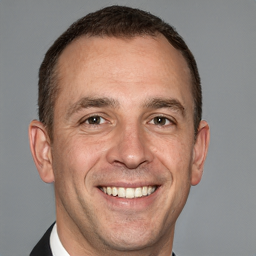

In [ ]:
torch.manual_seed(12)

sample_z = torch.randn(1, latent_len, dtype=torch.float32, device=torch.device(device))
latent_w = torch.tensor(generator.get_latent(sample_z))

input_image, input_latent = generator([latent_w], truncation=truncation, truncation_latent=trunc, input_is_latent=True, return_latents=True)

input_img = Image.open('/content/stylegan2-pytorch/sample/input.png')
input_img

In [ ]:
from torch import nn

loss_points = []
latent_w = torch.tensor(input_latent, requires_grad=True)
learning_rate = 0.1
loss_fn = nn.MSELoss()

for i in range(10000):
    step = i % 1000 # [0, ..., 9]
    if step < 9:
        learning_rate = 0.1
    else:
        learning_rate = 0.01
    optimizer = torch.optim.SGD([latent_w], lr=learning_rate, momentum=0.9)
    optimizer.zero_grad()
    gan_image, latent = generator([latent_w], truncation=truncation, truncation_latent=trunc, input_is_latent=True, return_latents=True)
    loss = loss_fn(gan_image.to(device), goal_image)
    loss_points.append(loss.item())
    if i % 1000 == 0:
        print('loss', loss.item())
        utils.save_image(
            gan_image,
            f"sample/{str(i).zfill(6)}.png",
            nrow=1,
            normalize=True,
            range=(-1, 1),
        )
    latent_w.requires_grad_()
    loss.backward(retain_graph=True)
   # torch.nn.utils.clip_grad_norm_([latent_w], max_norm)
    optimizer.step()


utils.save_image(
    gan_image,
    f"sample/final.png",
    nrow=1,\
    normalize=True,
    range=(-1, 1),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/content/stylegan2-pytorch/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.0+cu111. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


loss 0.18283355236053467
loss 0.1721785068511963
loss 0.16234774887561798
loss 0.15501099824905396
loss 0.15111953020095825
loss 0.15014822781085968
loss 0.14617232978343964
loss 0.142825186252594
loss 0.1415986716747284
loss 0.1393280327320099


# **Results**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_loss(y_points, title = 'Loss'):
    x_points = np.arange(0, len(y_points))

    plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=18, fontname='Times New Roman')
    plt.xlabel('Epoch', fontsize=16, fontname='Times New Roman')
    plt.ylabel('Score', fontsize=16, fontname='Times New Roman')
    plt.plot(x_points, y_points, color='#fb607f', linestyle='-')
    #plt.legend([''], loc='center', shadow=True, fontsize=18)
    plt.show()

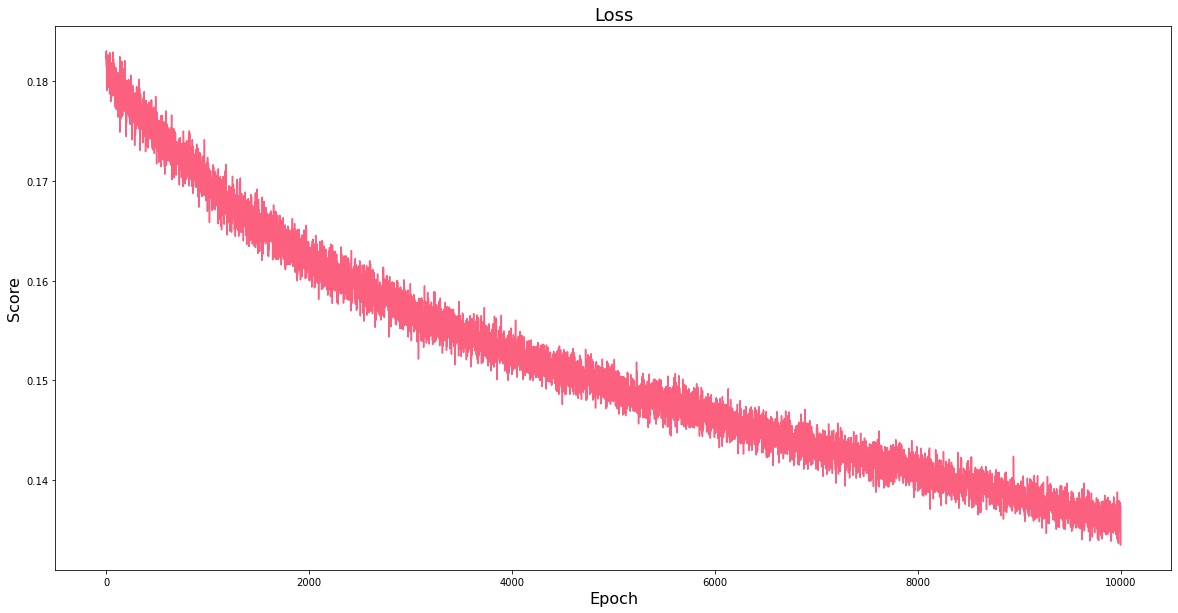

In [ ]:
plot_loss(loss_points)

In [ ]:
import os

def plot_pictures():
    images = []
    #images.append(Image.open('/content/drive/MyDrive/КУ Курсачи/Диплом/000003.png'))

    res_dir = '/content/stylegan2-pytorch/sample'
    list_dirs = os.listdir(res_dir)
    list_dirs.sort()
    for cur_file in list_dirs:
        images.append(Image.open(os.path.join(res_dir, cur_file)))

    fig = plt.figure(figsize=(10, 10))
    cols = 3
    rows = 4

    ax = []

    for i in range(cols * rows):
        image = images[i]
        ax.append(fig.add_subplot(rows, cols, i + 1))
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.show()


In [ ]:
plot_pictures()